In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Extracting dataset from the compressed zip file

In [ ]:
!unzip "/content/drive/MyDrive/Compressed DataSets/archive.zip" -d "/content/DataSet"

# Importing required packages and libraries

In [ ]:
import numpy as np
import os
import cv2
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# Path to the directory containing the brain tumor MRI images

In [ ]:
data_dir = "/content/DataSet/Training"
num_classes = 4  # Number of output classes (brain tumor types)

# Load and preprocess the MRI image

In [ ]:
def load_images(directory):
    images = []
    labels = []
    label_names = sorted(os.listdir(directory))  # Get the subdirectory names as labels
    label_mapping = {label_name: i for i, label_name in enumerate(label_names)}
    for label_name in label_names:
        label = label_mapping[label_name]  # Map the label name to an integer label
        folder_path = os.path.join(directory, label_name)
        for file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, file)
            image = cv2.imread(image_path)
            image = cv2.resize(image, (64, 64))
            images.append(image)
            labels.append(label)
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

# Load the MRI images and labels
images, labels = load_images(data_dir)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Preprocess the image data for the CNN
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Define CNN Model

In [ ]:
cnn_model = Sequential()
cnn_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(64, 64, 3)))
cnn_model.add(MaxPooling2D((2, 2)))

cnn_model.add(Conv2D(64, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))

cnn_model.add(Conv2D(128, (3, 3), activation='relu'))
cnn_model.add(MaxPooling2D((2, 2)))

cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dense(num_classes, activation='softmax'))  # Output layer with num_classes neurons

print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 6, 6, 128)        0

# Compiling and training the CNN Model

In [ ]:
epochs = 10  # Specify the number of epochs
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train, y_train, epochs=epochs, batch_size=32, validation_data=(X_test, y_test))

# Extract features from the CNN model
cnn_features = cnn_model.predict(X_train)

Epoch 1/10
143/143 [==============================] - 42s 290ms/step - loss: 0.0511 - accuracy: 0.9838 - val_loss: 0.2146 - val_accuracy: 0.9431
Epoch 2/10
143/143 [==============================] - 36s 250ms/step - loss: 0.0664 - accuracy: 0.9753 - val_loss: 0.1797 - val_accuracy: 0.9536
Epoch 3/10
143/143 [==============================] - 35s 243ms/step - loss: 0.0224 - accuracy: 0.9932 - val_loss: 0.1602 - val_accuracy: 0.9598
Epoch 4/10
143/143 [==============================] - 34s 241ms/step - loss: 0.0118 - accuracy: 0.9974 - val_loss: 0.2107 - val_accuracy: 0.9545
Epoch 5/10
143/143 [==============================] - 35s 244ms/step - loss: 0.0099 - accuracy: 0.9972 - val_loss: 0.2124 - val_accuracy: 0.9431
Epoch 6/10
143/143 [==============================] - 34s 237ms/step - loss: 0.0143 - accuracy: 0.9943 - val_loss: 0.3784 - val_accuracy: 0.9221
Epoch 7/10
143/143 [==============================] - 34s 239ms/step - loss: 0.0404 - accuracy: 0.9862 - val_loss: 0.2889 - val_ac

# Perform hyperparameter tuning for SVM classifier

In [ ]:
param_grid = {
    'C': [1, 10, 100],
    'gamma': [0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear', 'sigmoid']
}

svm_classifier = SVC()
svm_grid = GridSearchCV(svm_classifier, param_grid, cv=5)
svm_grid.fit(cnn_features, y_train)

# Get the best SVM model
best_svm_model = svm_grid.best_estimator_

# Evaluate the hybrid model on the test set

In [ ]:
cnn_test_features = cnn_model.predict(X_test)
svm_accuracy = best_svm_model.score(cnn_test_features, y_test)
print("Hybrid Model Accuracy: ", end="")
print("%.2f" % (svm_accuracy * 100))
print("Best SVM parameters: ", svm_grid.best_params_)

# Testing the model

1/1 [==============================] - 0s 24ms/step
Predicted class: meningioma


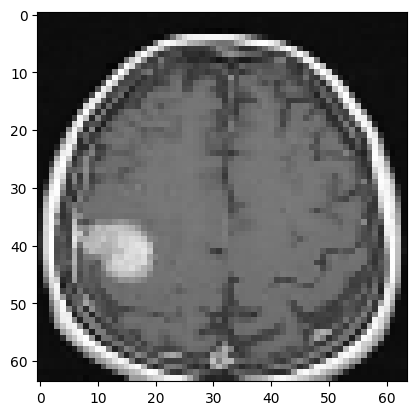

In [ ]:
label_names = np.unique(labels)

# Load and preprocess the new test image
test_image_path = '/content/DataSet/Testing/meningioma/Te-me_0023.jpg'
test_image = cv2.imread(test_image_path)
test_image = cv2.resize(test_image, (64, 64))
test_image = np.expand_dims(test_image, axis=0)
test_image = test_image.astype('float32') / 255.0

# Extract features from the CNN model
cnn_features = cnn_model.predict(test_image)

# Classify the test image using the SVM model
prediction = best_svm_model.predict(cnn_features)

# Create a dictionary mapping class labels to class names
label_to_name = {0 : "glioma", 1 : "meningioma", 2 : "no tumor", 3 : "pituitary"}

# Get the predicted class name
predicted_class_name = label_to_name[prediction[0]]

print("Predicted class:", predicted_class_name)

img_data = np.array(test_image)
img_data = np.reshape(img_data, (64, 64, 3))
img_data.shape
plt.imshow(img_data)
plt.show()

# Pictorial representation of the behaviour of the model

Epoch 1/10
143/143 [==============================] - 38s 266ms/step - loss: 0.0351 - accuracy: 0.9888 - val_loss: 0.2718 - val_accuracy: 0.9178
Epoch 2/10
143/143 [==============================] - 36s 253ms/step - loss: 0.0191 - accuracy: 0.9943 - val_loss: 0.2807 - val_accuracy: 0.9344
Epoch 3/10
143/143 [==============================] - 39s 274ms/step - loss: 0.0124 - accuracy: 0.9965 - val_loss: 0.2570 - val_accuracy: 0.9440
Epoch 4/10
143/143 [==============================] - 40s 278ms/step - loss: 9.1783e-04 - accuracy: 1.0000 - val_loss: 0.2847 - val_accuracy: 0.9484
Epoch 5/10
143/143 [==============================] - 36s 252ms/step - loss: 4.0738e-04 - accuracy: 1.0000 - val_loss: 0.2839 - val_accuracy: 0.9501
Epoch 6/10
143/143 [==============================] - 38s 267ms/step - loss: 2.8605e-04 - accuracy: 1.0000 - val_loss: 0.2926 - val_accuracy: 0.9501
Epoch 7/10
143/143 [==============================] - 36s 253ms/step - loss: 2.2466e-04 - accuracy: 1.0000 - val_loss:

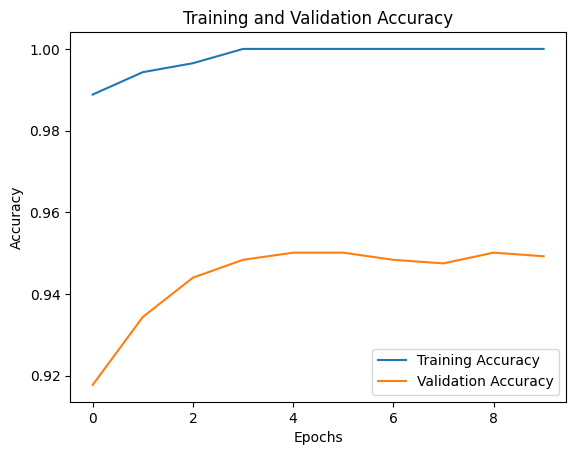

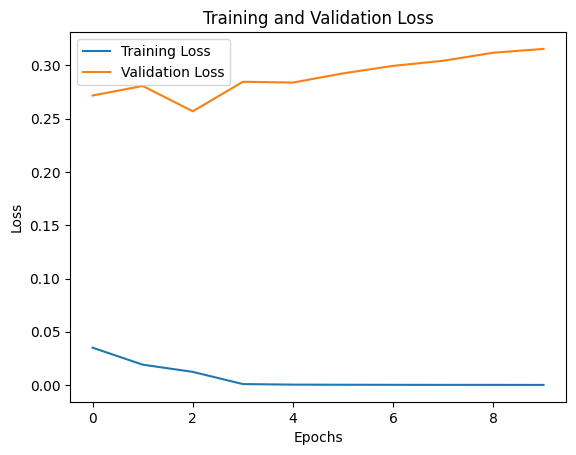

In [ ]:
# Get the training history
history = cnn_model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Plot the training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()

# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

